<a href="https://colab.research.google.com/github/arpanbiswas52/Preisach/blob/main/Graphene_examples_jrVAE_optimizeKL(LatentBO)v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning (jointly) discrete and continuous representations of the arbitrary rotated image data


---

Here we introduce a joint (rotationally-invariant) VAE that can perform unsupervised classification and disentangle relevant continuous factors of variation at the same time.


---





jrVAE model prepared by Maxim Ziatdinov

KL factor optimization framework (using contrained BO) in 2D latent space (dimension recuction using VAE) prepared by Arpan Biswas

Workflow implemented on Graphene examples where we want to separate different classes of defects - no prior knowledge of # of defect classes

E-mail: ziatdinovmax@gmail.com

E-mail: arpanbiswas52@gmail.com

In [ ]:
#@title Installation
!pip install -q pyroved kornia
!pip install botorch #version 0.5.1
!pip install gpytorch #version 1.6.0
!pip install pyroved
!pip install atomai==0.5.2 > /dev/null

     |████████████████████████████████| 46 kB 2.6 MB/s 
     |████████████████████████████████| 474 kB 16.5 MB/s 
     |████████████████████████████████| 713 kB 40.4 MB/s 
     |████████████████████████████████| 325 kB 7.2 MB/s 
     |████████████████████████████████| 310 kB 36.8 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=5f418b584724a6fbb20fd4a68e1deb781e6bcddbe1f235f5586a9fa1188235c3
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [ ]:
#@title Imports
from typing import Tuple

import pyroved as pv
import torch
import kornia as K
import kornia.metrics as metrics
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np
import random

# Import GP and BoTorch functions
import gpytorch as gpt
from botorch.models import SingleTaskGP, ModelListGP
#from botorch.models import gpytorch
from botorch.fit import fit_gpytorch_model
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import UpperConfidenceBound
from botorch.optim import optimize_acqf
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from botorch.sampling import SobolQMCNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan

from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions

from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from smt.sampling_methods import LHS
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
from scipy.interpolate import interp1d

import atomai as aoi

In [ ]:
#@title Helper functions

def generate_1Dspectra_Segment(degree, nsamples) -> torch.Tensor:
   
    dataset = []
    points = []
    slopes = []

    for i in range(nsamples):

        x = np.linspace(-1, 1, 120)
        segment_x = np.array([-1]+list(sorted(np.random.uniform(-1, 1, degree)))+[1])
        segment_y = np.random.uniform(0, 1, degree+2)
        points.append(torch.from_numpy(segment_x))

        slope = np.zeros(degree+1)
        for j in range(len(slope)):
          slope[j] = (segment_y[j+1]-segment_y[j])/(segment_x[j+1]-segment_x[j])
        slope = torch.from_numpy(slope)

        f2 = interp1d(segment_x, segment_y, kind='linear')
        f2 = f2(x)
        f2 = torch.from_numpy(f2).type(torch.float)
        noise = torch.randint(0, 50, (1,)) / 1e3
        #noise = 0 # no noise

        data_t = f2 + noise * torch.randn(size=(len(x),))
        dataset.append(data_t)
        slopes.append(slope)

    dataset = torch.cat(dataset).reshape(nsamples,120)
    points = torch.cat(points).reshape(nsamples, degree+2)
    slopes = torch.cat(slopes).reshape(nsamples, degree+1)

    # dataset = (dataset - dataset.min()) / (dataset.max() - dataset.min())
    return dataset, points, slopes

#Functions defined for problem and objectives

#Task

- Build objective function with maximizing mean loss or the Structural dissimilarity (DSSIM) among the manifolds representing each discrete class

- Build BO framework after reducing the high dimension trajectory hyper-parameter. Here from sensitivity analysis, we found the time-dependent trajectory, which varies the performance of VAE, depends on 4 independent components- time to start cool down, starting value, rate of cooldown and final value. We can reduce a large dimensional problem (>100D) into 4D problem.

In [ ]:
#@title SSIM loss function between images
def ssim_loss(
    img1: torch.Tensor,
    img2: torch.Tensor,
    window_size: int,
    max_val: float = 1.0,
    eps: float = 1e-12,
    reduction: str = 'mean',
) -> torch.Tensor:
    r"""Function that computes a loss based on the SSIM measurement.

    The loss, or the Structural dissimilarity (DSSIM) is described as:

    .. math::

      \text{loss}(x, y) = \frac{1 - \text{SSIM}(x, y)}{2}

    See :meth:`~kornia.losses.ssim` for details about SSIM.

    Args:
        img1: the first input image with shape :math:`(B, C, H, W)`.
        img2: the second input image with shape :math:`(B, C, H, W)`.
        window_size: the size of the gaussian kernel to smooth the images.
        max_val: the dynamic range of the images.
        eps: Small value for numerically stability when dividing.
        reduction : Specifies the reduction to apply to the
         output: ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
         ``'mean'``: the sum of the output will be divided by the number of elements
         in the output, ``'sum'``: the output will be summed.

    Returns:
        The loss based on the ssim index.

    Examples:
        >>> input1 = torch.rand(1, 4, 5, 5)
        >>> input2 = torch.rand(1, 4, 5, 5)
        >>> loss = ssim_loss(input1, input2, 5)
    """
    # compute the ssim map
    ssim_map: torch.Tensor = metrics.ssim(img1, img2, window_size, max_val, eps)

    # compute and reduce the loss
    loss = torch.clamp((1.0 - ssim_map) / 2, min=0, max=1)

    if reduction == "mean":
        loss = torch.mean(loss)
    elif reduction == "sum":
        loss = torch.sum(loss)
    elif reduction == "none":
        pass
    return loss


In [ ]:
#@title SSIM Loss objective function- Combined objective to minimize the ssim among the manifolds representing discrete classes, thus maximize the loss; and to maximize the ssim within the manifolds representing each discrete classes, thus minimize the loss
def loss_obj(X, kl_d, data, batch_size, B, H, W, discrete_dim):
    # xx=float(X)
    pen = 10**0
    data_dim = (H, W)
    M = torch.empty(B*B, H, W, discrete_dim)
    loss1 = 0
    loss2 = 0
    train_loader_X = pv.utils.init_dataloader(data, batch_size=batch_size)
    jvae_X = pv.models.jiVAE(data_dim, latent_dim=2, discrete_dim=discrete_dim, invariances=['r'], seed=42)

    trainer_X = pv.trainers.SVItrainer(jvae_X, lr=1e-3, enumerate_parallel=True)

    kl_scale = torch.from_numpy(X)
    #print(kl_scale.shape)
    for i in range(120):
        sc = kl_scale[i] if i < len(kl_scale) else kl_scale[-1]
        trainer_X.step(train_loader_X, scale_factor=[sc, kl_d])
        #loss[i] = trainer_X.loss_history["training_loss"][-1]

    for i in range(discrete_dim):
        M[:,:,:,i] = jvae_X.manifold2d(d=B, disc_idx=i, plot= False)

    M = torch.reshape(M, (M.shape[0], 1, M.shape[1], M.shape[2], M.shape[3]))
    k1 = 0
    #Objective 1 is to minimize the ssim among the manifolds representing discrete classes, thus maximize the loss
    for i in range(discrete_dim):
        for j in range(discrete_dim):
            if (j > i):
                M1 = M[:,:,:,:,i]
                M2 = M[:,:,:,:,j]
                # Compute SSIM/loss among each manifolds
                loss1 = loss1 + ssim_loss(M1, M2, 5)
                k1 = k1 + 1
    obj1 = (loss1/k)*pen

    #Objective 2 is to maximize the ssim within the manifolds representing each discrete classes, thus minimize the loss
    
    np.random.seed(0)
    n_image = 1000
    idxy = np.random.randint(0, B*B, (n_image, 2))
    for i in range(discrete_dim):
      k2 = 0
      l2 = 0
      for j in range(n_image):
        if (idxy[i, 0] is not idxy[i, 1]):
          loc1 = idxy[i, 0]
          loc2 = idxy[i, 1]
          m1 = M[loc1, :, :, :, i]
          m2 = M[loc2, :, :, :, i]
          # Compute SSIM/loss within each manifolds
          l2 = l2 + ssim_loss(m1, m2, 5)
          k2 = k2 + 1
      
      loss2 = loss2 + (l2/k2)

    obj2 = (loss2/discrete_dim)*pen
    
    obj = obj1 - obj2 # obj2 converted into maximization problem
  
    return obj

In [ ]:
#@title SSIM Loss objective function - Objective is to minimize the ssim among the manifolds representing discrete classes, thus maximize the loss
def loss_obj2(X, kl_d, data, batch_size, B, H, W, discrete_dim):
    # xx=float(X)
    data_dim = (H, W)
    M = torch.empty(B*B, H, W, discrete_dim)
    loss = 0
    train_loader_X = pv.utils.init_dataloader(data, batch_size=batch_size)
    jvae_X = pv.models.jiVAE(data_dim, latent_dim=2, discrete_dim=discrete_dim, invariances=['r'], seed=42)

    trainer_X = pv.trainers.SVItrainer(jvae_X, lr=1e-3, enumerate_parallel=True)

    kl_scale = torch.from_numpy(X)
    #print(kl_scale.shape)
    for i in range(120):
        sc = kl_scale[i] if i < len(kl_scale) else kl_scale[-1]
        trainer_X.step(train_loader_X, scale_factor=[sc, kl_d])
        #loss[i] = trainer_X.loss_history["training_loss"][-1]
    
    for i in range(discrete_dim):
        M[:,:,:,i] = jvae_X.manifold2d(d=B, disc_idx=i, plot= False)

    M = torch.reshape(M, (M.shape[0], 1, M.shape[1], M.shape[2], M.shape[3]))
    k = 0
    for i in range(discrete_dim):
        for j in range(discrete_dim):
            if (j > i):
                M1 = M[:,:,:,:,i]
                M2 = M[:,:,:,:,j]
                # Compute SSIM/loss among each manifolds
                loss = loss + ssim_loss(M1, M2, 5)
                k = k + 1
    pen = 10**0
    #Objective is to minimize the ssim among the manifolds representing discrete classes, thus maximize the loss
    obj = (loss/k)*pen

    return obj

In [ ]:
#@title Eliminate infeasible latent space from data
def getfeasible(X, fix_model):
  X_f = np.zeros((X.shape[1]**X.shape[0], X.shape[0]))
  z = torch.empty((1,2))
  k = 0
  for t1 in range(0, X.shape[1]):
    for t2 in range(0, X.shape[1]):
        z[0, 0] = X[0, t1]
        z[0, 1] = X[1, t2]
        decoded_traj = fix_model.decode(z).numpy()
        if (np.min(decoded_traj) > 0):
          #decoded_traj_feas[t1, t2] = 1 #1 denotes feasible
          X_f[k, 0] = X[0, t1]
          X_f[k, 1] = X[1, t2]
          k = k+1
        else:
          #decoded_traj_feas[t1, t2] = 0 #0 denotes infeasible
          X_f[k, 0] = np.inf
          X_f[k, 1] = np.inf
          k = k+1
        
  X_feas = np.transpose(np.vstack((X_f[~np.isinf(X_f[:,0]),0], X_f[~np.isinf(X_f[:,1]),1])))
  X_feas = torch.from_numpy(X_feas)
  #print(X_f.shape)
  #print(X_feas.shape)
  return X_feas

#Functions defined for BO architecture

Below section defines the list of functions (user calls these functions during analysis):
1. Gaussian Process
2. Optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
3. Posterior means and variance computation
4. Acquistion functions for BO- Expected Improvmement

In [ ]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        #self.mean_module = LinearMean(train_X.shape[-1])
        self.covar_module = ScaleKernel(
            #base_kernel=MaternKernel(nu=2.5, ard_num_dims=train_X.shape[-1]),
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

#Optimize Hyperparameters of GP#
def optimize_hyperparam_trainGP(train_X, train_Y):
    # Gp model fit

    gp_surro = SimpleCustomGP(train_X, train_Y)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood, gp_surro)
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X)
    gp_surro.train()
    gp_surro.likelihood.train()
    ## Here we use Adam optimizer with learning rate =0.1, user can change here with different algorithm and/or learning rate for each GP
    optimizer1 = Adam([{'params': gp_surro.parameters()}], lr=0.0001)
    #optimizer1 = SGD([{'params': gp_surro.parameters()}], lr=0.0001)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro(train_X)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss:" + str(loss1.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise:" + str(gp_surro.likelihood.noise.item()))


        optimizer1.step()

    gp_surro.eval()
    gp_surro.likelihood.eval()
    return gp_surro


#GP posterior predictions#
def cal_posterior(gp_surro, test_X):
    y_pred_means = torch.empty(len(test_X), 1)
    y_pred_vars = torch.empty(len(test_X), 1)
    t_X = torch.empty(1, test_X.shape[1])
    for t in range(0, len(test_X)):
        with torch.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
            gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                      solves=True), \
            gpt.settings.max_cg_iterations(100), \
            gpt.settings.max_preconditioner_size(80), \
            gpt.settings.num_trace_samples(128):

                t_X[:, 0] = test_X[t, 0]
                t_X[:, 1] = test_X[t, 1]
                #t_X = test_X.double()
                y_pred_surro = gp_surro.posterior(t_X)
                y_pred_means[t, 0] = y_pred_surro.mean
                y_pred_vars[t, 0] = y_pred_surro.variance

    return y_pred_means, y_pred_vars


#EI acquistion function#
def acqmanEI(y_pred_means, y_pred_vars, train_Y):


    y_pred_means = y_pred_means.detach().numpy()
    y_pred_vars = y_pred_vars.detach().numpy()
    fmax = train_Y.max()
    fmax = fmax.detach().numpy()
    best_value = fmax
    EI_val = np.zeros(len(y_pred_vars))
    Z = np.zeros(len(y_pred_vars))
    eta = 0.001
    
    for i in range(0, len(y_pred_vars)):
        if (y_pred_vars[i] <=0):
            EI_val[i] = 0
        else:
            Z[i] =  (y_pred_means[i]-best_value-eta)/y_pred_vars[i]
            EI_val[i] = (y_pred_means[i]-best_value-eta)*norm.cdf(Z[i]) + y_pred_vars[i]*norm.pdf(Z[i])

    acq_val = np.max(EI_val)
    acq_cand = [k for k, j in enumerate(EI_val) if j == acq_val]
    return acq_cand, acq_val, EI_val

#Other list of functions-

1. Evaluate initial data and normalize all data
2. Evaluate functions for new data and augment data

In [ ]:
# Normalize all data. It is very important to fit GP model with normalized data to avoid issues such as
# - decrease of GP performance due to largely spaced real-valued data X.
def normalize_get_initialdata_KL(X, fix_params, data, fix_model, num_rows, num, m):
    
    #Eliminate infeasible region in the latent space
    X_feas = getfeasible(X, fix_model)
    
    X_feas_norm = torch.empty((X_feas.shape[0], X_feas.shape[1]))
    #train_X = torch.empty((len(X), num))
    #train_X_norm = torch.empty((len(X), num))
    train_Y = torch.empty((num, 1))

    # Normalize X
    for i in range(0, X_feas.shape[1]):
        X_feas_norm[:, i] = (X_feas[:, i] - torch.min(X_feas[:, i])) / (torch.max(X_feas[:, i]) - torch.min(X_feas[:, i]))
      
    

    # Select starting samples randomly as training data
    np.random.seed(0)
    idx = np.random.randint(0, len(X_feas), num)
    train_X = X_feas[idx]
    train_X_norm = X_feas_norm[idx]

    #Evaluate initial training data
    z = torch.empty((1,2))
    for i in range(0, num):
        z[0, 0] = train_X[i, 0]
        z[0, 1] = train_X[i, 1]
        decoded_traj = fix_model.decode(z).numpy()
        decoded_traj1= np.reshape(decoded_traj, (decoded_traj.shape[0]*decoded_traj.shape[1]))
        print("Function eval #" + str(m + 1))
        kl_d, batch_size, B, H, W, discrete_dim  = fix_params[0], fix_params[1], fix_params[2], fix_params[3], fix_params[4], fix_params[5]

        train_Y[i, 0] = loss_obj2(decoded_traj1, kl_d, data, batch_size, B, H, W, discrete_dim)
        m = m + 1

    return X_feas, X_feas_norm, train_X, train_X_norm, train_Y, m


################################Augment data - Existing training data with new evaluated data################################
def augment_newdata_KL(acq_X, acq_X_norm, train_X, train_X_norm, train_Y, fix_params, data, fix_model, m):
    nextX = acq_X
    nextX_norm = acq_X_norm
    #train_X_norm = torch.cat((train_X_norm, nextX_norm), 0)
    #train_X_norm = train_X_norm.double()
    train_X_norm = torch.vstack((train_X_norm, nextX_norm))
    train_X = torch.vstack((train_X, nextX))
    next_feval = torch.empty(1, 1)
    z = torch.empty((1,2))
    z[0, 0] = train_X[-1, 0]
    z[0, 1] = train_X[-1, 1]
    decoded_traj = fix_model.decode(z).numpy()
    decoded_traj1= np.reshape(decoded_traj, (decoded_traj.shape[0]*decoded_traj.shape[1]))
    print("Function eval #" + str(m + 1))
    kl_d, batch_size, B, H, W, discrete_dim = fix_params[0], fix_params[1], fix_params[2], fix_params[3], fix_params[4], \
                                              fix_params[5]

    next_feval[0, 0] = loss_obj2(decoded_traj1, kl_d, data, batch_size, B, H, W, discrete_dim)

    train_Y = torch.vstack((train_Y, next_feval))

    #train_Y = torch.cat((train_Y, next_feval), 0)
    m = m + 1
    return train_X, train_X_norm, train_Y, m

In [ ]:
#@title Functions to plot KL trajectories at specific BO iterations
def plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_model, i):
    pen = 10**0
    #Best solution among the evaluated data
    
    loss = torch.max(train_Y)
    ind = torch.argmax(train_Y)
    z_opt = torch.empty((1,2))
    #X_opt = train_X[ind, :]
    z_opt[0, 0] = train_X[ind, 0]
    z_opt[0, 1] = train_X[ind, 1]
    decoded_traj = fix_model.decode(z_opt).numpy()
    decoded_traj1= np.reshape(decoded_traj, (decoded_traj.shape[0]*decoded_traj.shape[1]))
    kl_scale_eval = torch.from_numpy(decoded_traj1)
    n = len(kl_scale_eval)
    plt.plot(np.linspace(1, n, n), kl_scale_eval.detach().numpy(), 'ro-', markersize=2, linewidth=1)
    plt.xlabel("steps")
    plt.ylabel("kl")
    plt.title("Best evaluated solution at iteration: "+str(i)+", Loss:" +str(loss/pen))
    #print("Loss: " + str(loss))
    plt.show()

    # Best estimated solution from GP model considering the non-evaluated solution
    #robust_Y = y_pred_means - (y_pred_vars/2) # Increasing preference, (r = mu - (sigma2/2*rho)), risk attitute, rho = 1
    robust_Y = y_pred_means
    loss = torch.max(robust_Y)
    ind = torch.argmax(robust_Y)
    z_opt_robust = torch.empty((1,2))
    #X_opt = train_X[ind, :]
    z_opt_robust[0, 0] = test_X[ind, 0]
    z_opt_robust[0, 1] = test_X[ind, 1]
    decoded_traj = fix_model.decode(z_opt_robust).numpy()
    decoded_traj1= np.reshape(decoded_traj, (decoded_traj.shape[0]*decoded_traj.shape[1]))
    kl_scale_est = torch.from_numpy(decoded_traj1)
    n = len(kl_scale_est)
    plt.plot(np.linspace(1, n, n), kl_scale_est.detach().numpy(), 'ro-', markersize=2, linewidth=1)
    plt.xlabel("steps")
    plt.ylabel("kl")
    plt.title("Best estimated solution at iteration: "+str(i)+", Loss:" +str(y_pred_means[ind]/pen))
    #print("Loss: " + str(loss))
    plt.show()

    #Objective map over 2D latent space
    a = plt.scatter(test_X[:,0], test_X[:,1], c=y_pred_means/pen, cmap='viridis', linewidth=0.2)
    plt.scatter(train_X[:,0], train_X[:,1], marker='o', c='g')
    plt.scatter(z_opt[0, 0], z_opt[0, 1], marker='x', c='r')
    plt.scatter(z_opt_robust[0, 0], z_opt_robust[0, 1], marker='o', c='r')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Objective (SSIM loss) map over feasible 2D latent space')
    plt.colorbar(a)
    plt.show()
    
    #Objective map over 2D latent space
    plt.scatter(test_X[:,0], test_X[:,1], c=y_pred_vars/(pen**2), cmap='viridis', linewidth=0.2)
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Objective var map over feasible 2D latent space')
    plt.colorbar()
    plt.show()

    return kl_scale_eval, kl_scale_est

In [ ]:
#@title BO framework- Integrating the above functions
def latentBO_KL(X, fix_params, data, fix_model, num_rows, num_start, N):
    num = num_start
    m = 0
    # Initialization: evaluate few initial data normalize data
    test_X, test_X_norm, train_X, train_X_norm, train_Y, m = \
        normalize_get_initialdata_KL(X, fix_params, data, fix_model, num_rows, num, m)


    print("Initial evaluation complete. Start BO")
    ## Gp model fit
    # Calling function to fit and optimizize Hyperparameter of Gaussian Process (using Adam optimizer)
    # Input args- Torch arrays of normalized training data, parameter X and objective eval Y
    # Output args- Gaussian process model lists
    gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

    for i in range(1, N + 1):
        # Calculate posterior for analysis for intermidiate iterations
        y_pred_means, y_pred_vars = cal_posterior(gp_surro, test_X_norm)
        if (i == 1 or i == 10 or i == 30 or i == 50 or i == 80 or i == 100 or i == 200 or i == 275 or i == 350):
            # Plotting functions to check the current state exploration and Pareto fronts
            kl_scale_eval, kl_scale_est = plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_model, i)

        acq_cand, acq_val, EI_val = acqmanEI(y_pred_means, y_pred_vars, train_Y)
        val = acq_val
        ind = np.random.choice(acq_cand)

        ################################################################
        ## Find next point which maximizes the learning through exploration-exploitation
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) <= 1e-10):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            nextX = torch.empty((1, len(X)))
            nextX_norm = torch.empty(1, len(X))
            nextX[0,:] = test_X[ind, :]
            nextX_norm [0, :] = test_X_norm[ind, :]

            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, m = augment_newdata_KL(nextX, nextX_norm, train_X, train_X_norm,train_Y, fix_params, data, fix_model, m)

            # Gp model fit
            # Updating GP with augmented training data
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y)

    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Optimal GP learning
    gp_opt = gp_surro
    # Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_opt, test_X_norm)
    # Plotting functions to check final iteration
    kl_scale_eval_opt, kl_scale_est_opt = plot_iteration_results(train_X, train_Y, test_X, y_pred_means, y_pred_vars, fix_model, i)

    return  kl_scale_eval_opt, kl_scale_est_opt, gp_opt, train_X, train_Y

#Prepare a set of KL trajectories

Create the set of the possible trajectories. Here, we define trajectories from different functionals in real space.

With these, we 
- define the 2D latent space to sample from (i.e. pretrain)
- draw the point form the space and evaluate the jrVAE model
- build a BO framework in the reduced 2D latent space for KL factor optimization 

In [ ]:
#Prepare training data to fit trajectory in a VAE model

torch.manual_seed(100)
num_samples1 = 2500
num_samples2 = 2500
num_traj = 120

#########Sampled trajectories defined from functional 1
traj_sampled1 = torch.empty((num_samples1, num_traj))
#Control parameters for defining KL trajectories -defined from functional 1
X_start = torch.linspace(50, 30, num_samples1)
X_stop = torch.linspace(5, 1, num_samples1)
X_coolrate = torch.linspace(80, 1, num_samples1)
X_timeout = torch.linspace(20, 1, num_samples1)

X= torch.vstack((X_start, X_stop, X_coolrate, X_timeout))
X= torch.transpose(X, 0, 1)
#print(X.shape)

for j in range(num_samples1):
    kl_scale_sampled = torch.cat(
        [torch.ones(int(np.round(X_timeout[j])),) * X_start[j],  # put pressure on the continuous latent channel at the beginning
        torch.linspace(X_start[j], X_stop[j], int(np.round(X_coolrate[j])))]  # gradually release the pressure
    )

    #Consider trajectory of 120 dimensions- defined by 4 variables (4D) in the real space
    for i in range(num_traj):
        traj_sampled1[j, i] = kl_scale_sampled[i] if i < len(kl_scale_sampled) else kl_scale_sampled[-1]


print(traj_sampled1.shape)

#########Sampled trajectories defined from functional 2
traj_sampled2, points, slopes = generate_1Dspectra_Segment(2, num_samples2)

#print(traj_sampled2.shape)
#Rescaling to similar sample data defined from func 1
traj_sampled2 = traj_sampled2.detach().numpy()

traj_sampled22 = np.reshape(traj_sampled2, num_samples2*num_traj)
#print(traj_sampled2.shape, traj_sampled22.shape)

traj_sampled22_norm = (traj_sampled22- np.min(traj_sampled22)) / (np.max(traj_sampled22) - np.min(traj_sampled22))
traj_sampled22_scaled = traj_sampled22_norm*(50-1) + 1
#print(traj_sampled22_scaled.shape, np.min(traj_sampled22_scaled), np.max(traj_sampled22_scaled))

traj_sampled22_scaled = np.reshape(traj_sampled22_scaled, (num_samples2, num_traj))
traj_sampled22_scaled = torch.from_numpy(traj_sampled22_scaled)
traj_sampled2 = torch.from_numpy(traj_sampled2)
print(traj_sampled22_scaled.shape, traj_sampled2.shape)


#Combine data sampled from both functionals
traj_sampled = torch.vstack((traj_sampled1, traj_sampled22_scaled))

print(traj_sampled.shape)

torch.Size([2500, 120])
torch.Size([2500, 120]) torch.Size([2500, 120])
torch.Size([5000, 120])


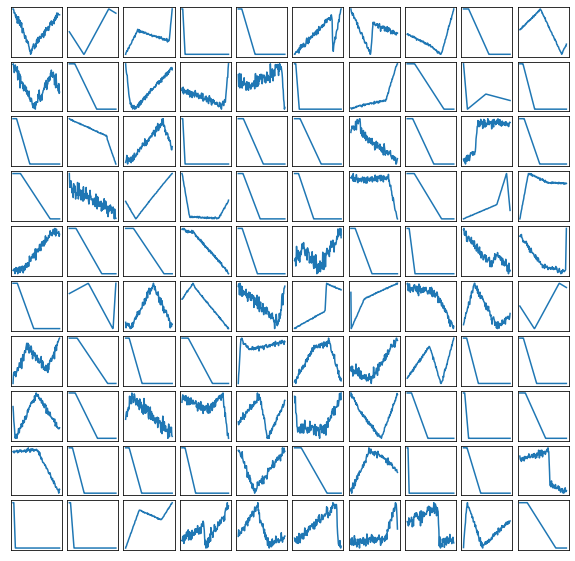

In [ ]:
#Plot the training data of sampled trajectories
num_samples = num_samples1 + num_samples2
t = np.linspace(1, 120, 120)
fig, axes = plt.subplots(
    10, 10, figsize=(10, 10), subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(0, num_samples)
    y_i = traj_sampled[i, :].detach().numpy()
    ax.plot(t, y_i)
    #ax.set_ylim (-1.1, 1.1)

We can see combination of different trajectories with various complexities- which are defined from more than 1 functionals.

- Now we train this combined trajectory data in a VAE model and convert into 2D latent space, thus reducing dimension for BO (Kl factor optimization)

# Train the VAE model with sampled trajectories

-Here we convert the trajectories in a 2D latent space

In [ ]:
train_loader_traj = pv.utils.init_dataloader(traj_sampled.unsqueeze(1), batch_size=64)

In [ ]:
# set the dimension of the spectra
in_dim = (num_traj,)

# Initialize invariant VAE
vae_traj = pv.models.iVAE(in_dim, latent_dim=2, invariances=None,
                      sampler_d="gaussian", decoder_sig=.3, sigmoid_d=False,
                      seed=0)

# Initialize SVI trainer
trainer_traj = pv.trainers.SVItrainer(vae_traj, lr=1e-4)

# Train for n epochs:
for e in range(1000):
    trainer_traj.step(train_loader_traj)
    trainer_traj.print_statistics()

Epoch: 1 Training loss: 367900.0423
Epoch: 2 Training loss: 334140.6952
Epoch: 3 Training loss: 303141.9516
Epoch: 4 Training loss: 279045.9630
Epoch: 5 Training loss: 258576.2837
Epoch: 6 Training loss: 240539.3244
Epoch: 7 Training loss: 224469.7288
Epoch: 8 Training loss: 209976.3896
Epoch: 9 Training loss: 196855.0064
Epoch: 10 Training loss: 184931.5525
Epoch: 11 Training loss: 174069.2908
Epoch: 12 Training loss: 164192.4069
Epoch: 13 Training loss: 155172.0076
Epoch: 14 Training loss: 146946.7556
Epoch: 15 Training loss: 139431.5798
Epoch: 16 Training loss: 132565.5803
Epoch: 17 Training loss: 126293.5166
Epoch: 18 Training loss: 120552.1360
Epoch: 19 Training loss: 115294.5320
Epoch: 20 Training loss: 110453.9938
Epoch: 21 Training loss: 105989.9457
Epoch: 22 Training loss: 101890.8777
Epoch: 23 Training loss: 98106.8570
Epoch: 24 Training loss: 94617.2890
Epoch: 25 Training loss: 91357.1380
Epoch: 26 Training loss: 88370.6898
Epoch: 27 Training loss: 85558.0207
Epoch: 28 Train

We see few limitations of the approach
- In a problem, domain experts is needed to initialize the ensemble of trajectories. Then the approach will guide them to find the best trajectory for training jrVAE model. It is assumed there will lie an optimum solution within the ensemble of trajectories.

- Secondly, the VAE model which convert the traj into 2D latent space should be trained well with sufficient minimization of loss. With bad training (high loss), the decode error can eliminate the preservation of the good trajectories (which was in the ensemble), therefore the optimum solution can get lost specifically if the optimum solution set is very sparse. In this MNIST problem, we know the optimum solution is cooldown where are segments are non-smooth (a very special case of 3 segments trajs- thus a narrow set of good solutions). With too much error after training, the segments get too smoothen which turns into bad solutions.

View the learned latent manifold:

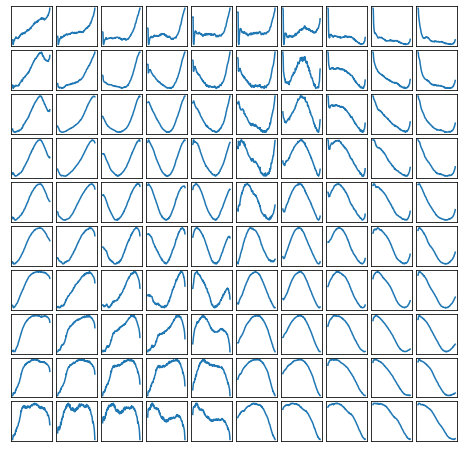

tensor([[ 4.2060,  3.8737,  2.3341,  ..., 15.2284, 15.8069, 16.9386],
        [ 5.1454,  4.5881,  1.4508,  ..., 16.0937, 16.6950, 17.8308],
        [ 9.4464,  9.0752,  4.1474,  ..., 19.2439, 19.4182, 20.2673],
        ...,
        [43.7198, 44.2937, 44.7669,  ..., 17.9043, 17.4652, 17.7420],
        [45.7427, 46.2790, 46.7885,  ..., 17.3965, 17.1701, 17.4760],
        [46.3805, 46.9674, 47.5324,  ..., 15.0671, 15.1739, 15.4221]])

In [ ]:
vae_traj.manifold2d(d=10)

Encode the training data into the latent space:

torch.Size([5000, 2]) torch.Size([5000, 2])


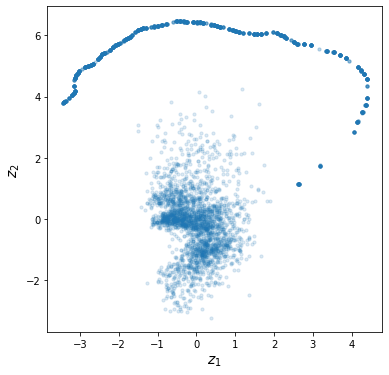

In [ ]:
train_data = train_loader_traj.dataset.tensors[0] 
#train_data = traj_sampled
z_mean_traj, z_sd_traj = vae_traj.encode(train_data)
print(z_mean_traj.shape, z_sd_traj.shape)
plt.figure(figsize=(6, 6))
plt.scatter(z_mean_traj[:, -2], z_mean_traj[:, -1], s=10, alpha = 0.15)
plt.xlabel("$z_1$", fontsize=14)
plt.ylabel("$z_2$", fontsize=14)
plt.show()


- Here we build a generalized VAE model to convert any defined trajectory (from different functionals) into a combined 2D latent space.

- We use this latent space as parameter space for BO optimization, after eliminating any infeasible (kl factors should be positive) domain.

Reconstruct a latent point:

tensor([-1.,  6.])


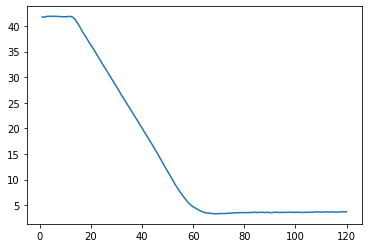

In [ ]:
# choose a latent coordinate to decode into nD real space (trajectory)
#z = [-2.23112, 8.12115] # From the above latent space figure, with a input of latent vars, we can have idea what kind of trajectories we can get (linear cooldown or random segmented)
z = [-1.0, 6.0]
z = torch.tensor(z)
print(z)
decoded_traj = vae_traj.decode(z).numpy()
plt.plot(t, decoded_traj.squeeze())

We see the training is done well, as we see the cooldown segemneted trajs are still preserved after converting into 2D latent space (with decoding the segments are not too smoothen)


- Lets divide the latent space into feasible and infeasible region

In [ ]:
z1_traj = np.linspace(torch.min(z_mean_traj[:, -2]), torch.max(z_mean_traj[:, -2]), 100)
z2_traj = np.linspace(torch.min(z_mean_traj[:, -1]), torch.max(z_mean_traj[:, -1]), 100)
z1_traj, z2_traj = np.meshgrid(z1_traj, z2_traj)
decoded_traj_feas = np.zeros((100, 100))
z = torch.empty((1,2))
m=1
for t1, (x1, x2) in enumerate(zip(z1_traj, z2_traj)):
  for t2, (xx1, xx2) in enumerate(zip(x1, x2)):
    #print("Evaluation # " +str(m))
    m = m+1
    z[0, 0] = xx1
    z[0, 1] = xx2
    decoded_traj = vae_traj.decode(z).numpy()
    if (np.min(decoded_traj) > 0):
      decoded_traj_feas[t1, t2] = 1 #1 denotes feasible
    else:
      decoded_traj_feas[t1, t2] = 0 #0 denotes infeasible

print(decoded_traj_feas.shape)
print(np.sum(decoded_traj_feas))

(100, 100)
8493.0


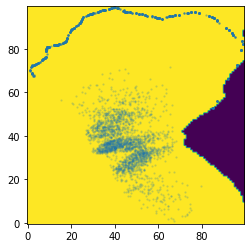

In [ ]:
#Plot the latent space and check feasible region
plt.imshow(decoded_traj_feas, origin="lower")
a1= (z_mean_traj[:, -2]- torch.min(z_mean_traj[:, -2])) / (torch.max(z_mean_traj[:, -2]) - torch.min(z_mean_traj[:, -2]))
a2= (z_mean_traj[:, -1]- torch.min(z_mean_traj[:, -1])) / (torch.max(z_mean_traj[:, -1]) - torch.min(z_mean_traj[:, -1]))
b1 = a1*(99-1) + 1
b2 = a2*(99-1) + 1
plt.scatter(b1, b2, s=2, alpha = 0.15)

- Here the dark region is the infeasible region and the light region is the feasible region

- The blue dots are the training data imposed on the latent space. 

We get some infeasible trajectory here- as kl factor can not be negative. 

- we can consider the latent space and simply use a constrained BO



#Now we start Analysis- Graphene problem
- KL trajectory optimization using BO over the 2D latent space which decodes sample trajectory into real space.

- We run the BO with subset of data. This is to reduce the cost of function evaluation (Expensive) during BO since the VAE model cost increases with data size. We assume the optimal trajectory should not be dependent to the data size, given the data originates from same black-box model (Graphene data)

Get training data and create a dataloader object

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')



Mounted at /content/drive/


Create a stack of submimages centered around a portion of the identified lattice atoms:

- Here we considered 600 images and window size 70 to build training data

In [ ]:
data = np.load("/content/drive/My Drive/Data/Gdata_for_VAE0.npz", allow_pickle=True)
coordinates, dcnn_out, imgdata = data.values()
coordinates = coordinates[()]  # array to dict

imstack_C, com_C, frames_C = aoi.utils.extract_random_subimages(
    dcnn_out, window_size=70, num_images=600, 
    coordinates=coordinates, coord_class=0)
imstack_C = imstack_C[..., 0]  # get rid of pseudo-channel dimension
print(imstack_C.shape)

(5000, 70, 70)


In [ ]:
imstack_Si, com_Si, frames_Si = aoi.utils.extract_subimages(
    dcnn_out, coordinates,
    window_size=70, coord_class=1)
imstack_Si = imstack_Si[..., 0] # get rid of pseudo-channel dimension
print(imstack_Si.shape)

(1654, 70, 70)


Add impurities

In [ ]:
add_impurities = True

if add_impurities:
    imstack = np.concatenate((imstack_C, imstack_Si), axis=0)
    com = np.concatenate((com_C, com_Si), axis=0)
    frames_all = np.concatenate((frames_C, frames_Si))
else:
    imstack = imstack_C
    com = com_C
    frames_all = frames_C

imstack = np.reshape(imstack, (imstack.shape[0], 1, imstack.shape[1], imstack.shape[2]))
imstack = torch.from_numpy(imstack)
print(imstack.shape, com.shape, frames_all.shape)
train_data = imstack.float()

torch.Size([6654, 1, 70, 70]) (6654, 2) (6654,)


#KL optimization using constrained BO over 2D latent space

Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO


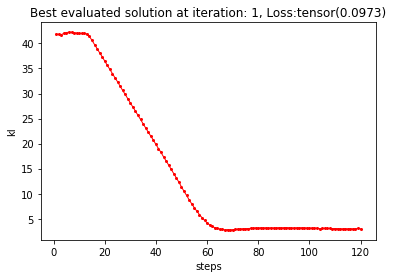

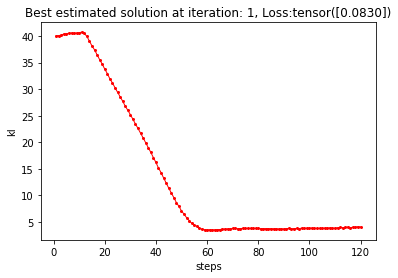

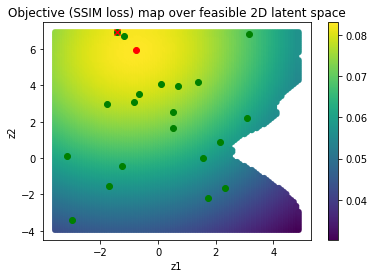

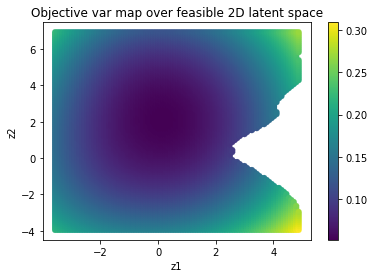

Function eval #21
Function eval #22
Function eval #23
Function eval #24
Function eval #25
Function eval #26
Function eval #27
Function eval #28
Function eval #29


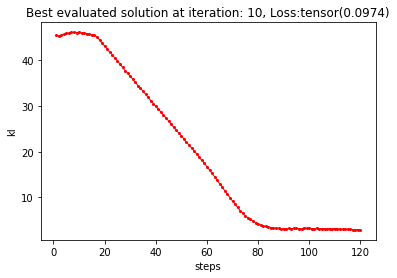

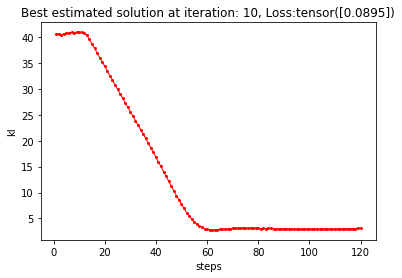

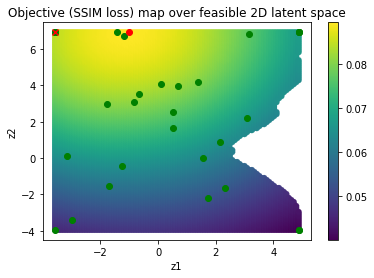

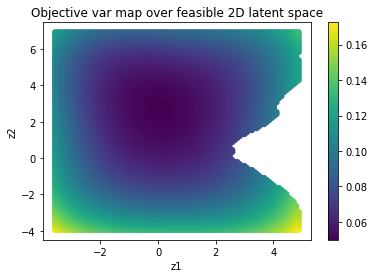

Function eval #30
Function eval #31
Function eval #32
Function eval #33
Function eval #34
Function eval #35
Function eval #36
Function eval #37
Function eval #38
Function eval #39
Function eval #40
Function eval #41
Function eval #42
Function eval #43
Function eval #44
Function eval #45
Function eval #46
Function eval #47
Function eval #48
Function eval #49


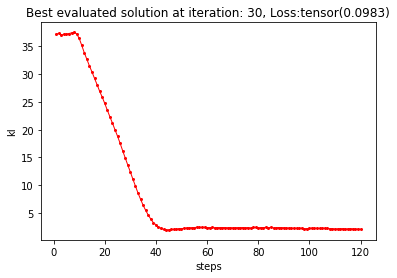

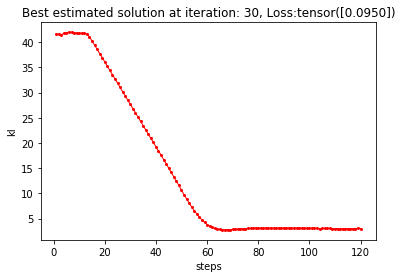

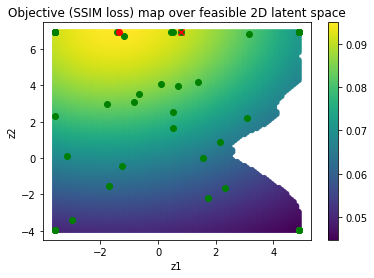

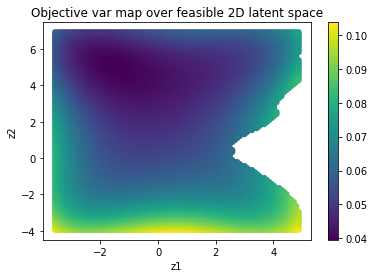

Function eval #50
Function eval #51
Function eval #52
Function eval #53
Function eval #54
Function eval #55
Function eval #56
Function eval #57
Function eval #58
Function eval #59
Function eval #60
Function eval #61
Function eval #62
Function eval #63
Function eval #64
Function eval #65
Function eval #66
Function eval #67
Function eval #68
Function eval #69


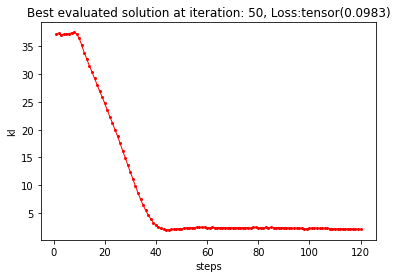

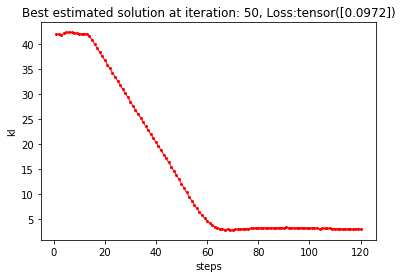

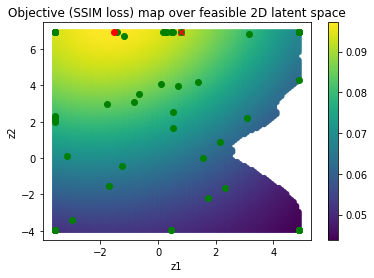

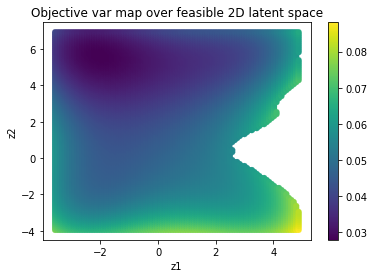

Function eval #70
Function eval #71
Function eval #72
Function eval #73
Function eval #74
Function eval #75
Function eval #76
Function eval #77
Function eval #78
Function eval #79
Function eval #80
Function eval #81
Function eval #82
Function eval #83
Function eval #84
Function eval #85
Function eval #86
Function eval #87
Function eval #88
Function eval #89
Function eval #90
Function eval #91
Function eval #92
Function eval #93
Function eval #94
Function eval #95
Function eval #96
Function eval #97
Function eval #98
Function eval #99


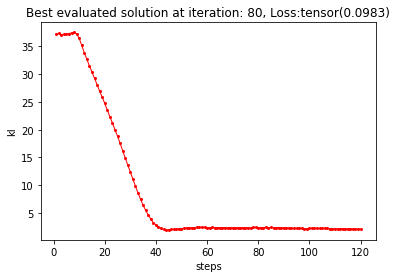

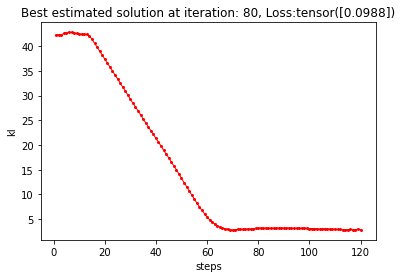

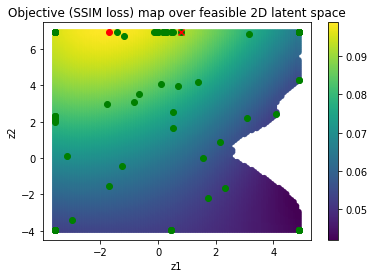

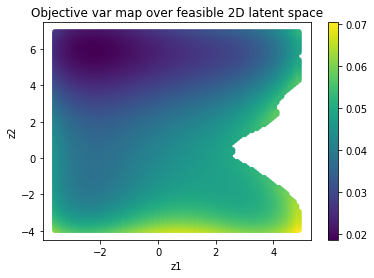

Function eval #100
Function eval #101
Function eval #102
Function eval #103
Function eval #104
Function eval #105
Function eval #106
Function eval #107
Function eval #108
Function eval #109
Function eval #110
Function eval #111
Function eval #112
Function eval #113
Function eval #114
Function eval #115
Function eval #116
Function eval #117
Function eval #118
Function eval #119


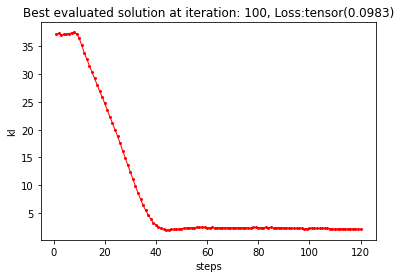

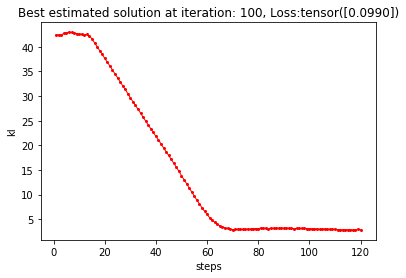

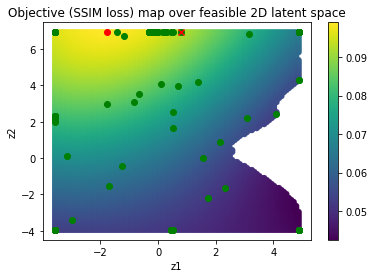

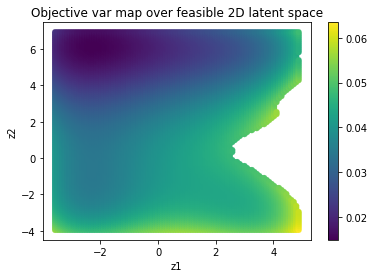

Function eval #120
Function eval #121
Function eval #122
Function eval #123
Function eval #124
Function eval #125
Function eval #126
Function eval #127
Function eval #128
Function eval #129
Function eval #130
Function eval #131
Function eval #132
Function eval #133
Function eval #134
Function eval #135
Function eval #136
Function eval #137
Function eval #138
Function eval #139
Function eval #140
Max. sampling reached, model stopped


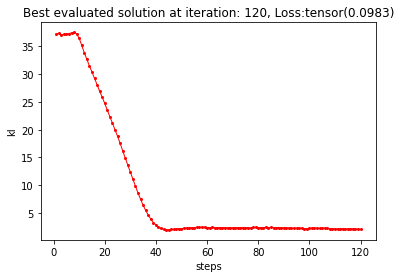

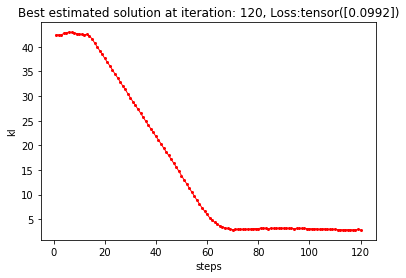

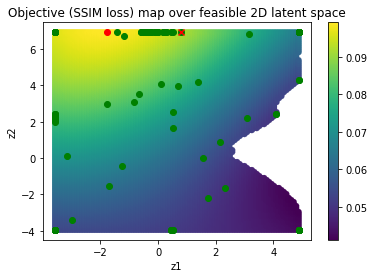

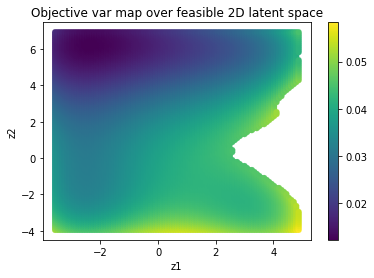

In [ ]:
batch_size=10
B = 12 #grid size for manifold2D
#Data dim size
H = 70
W = 70
#Initialize # of discrete class
discrete_dim = 10 #We dont have any prior knowledge with the actual # of discrete class of defects, we initialize arbitarily 
kl_d = 3
#Initialize for BO
num_rows =100
num_start = 20  # Starting samples
N= 120

#latent parameters for defining KL trajectories
z1_traj = torch.linspace(torch.min(z_mean_traj[:, -2]), torch.max(z_mean_traj[:, -2]), num_rows)
z2_traj = torch.linspace(torch.min(z_mean_traj[:, -1]), torch.max(z_mean_traj[:, -1]), num_rows)

Z= torch.vstack((z1_traj, z2_traj))
#print(Z.shape[1])
#Fixed parameters of VAE model
fix_params = [kl_d, batch_size, B, H, W, discrete_dim]
latent_model = vae_traj
#train_data_ss = train_data_ss.float()
#Z_feas = getfeasible(Z, latent_model)
kl_cont_eval_opt, kl_cont_est_opt, gp_opt, train_X, train_Y = latentBO_KL(Z, fix_params, train_data_ss, latent_model, num_rows, num_start, N)
np.save("kl_cont_eval_opt.npy", kl_cont_eval_opt)
np.save("kl_cont_est_opt.npy", kl_cont_est_opt)

In the figures over latent space,

- Green dots are all the evaluated locations at current stage

- Red cross is the best among evaluated solution at current stage

- Red dot is the best estimated solution at current stage. This is calculated based on posterior GP mean

Traj selected from BO

tensor([37.1871, 37.3312, 37.0110, 37.1629, 37.2014, 37.3030, 37.4191, 37.5328,
        37.2466, 36.4357, 35.1746, 33.8389, 32.6689, 31.4777, 30.3928, 29.2225,
        28.1057, 26.9127, 25.8672, 24.7124, 23.5168, 22.3281, 21.1853, 19.9924,
        18.8118, 17.5555, 16.2162, 14.9256, 13.6374, 12.3881, 11.0920,  9.8434,
         8.5978,  7.4767,  6.4034,  5.4750,  4.6444,  3.9026,  3.2778,  2.8998,
         2.4779,  2.2623,  2.0571,  1.9647,  1.9832,  2.0543,  2.0635,  2.0954,
         2.1982,  2.2072,  2.2427,  2.3211,  2.3559,  2.3567,  2.3938,  2.4328,
         2.4089,  2.4279,  2.4276,  2.3950,  2.3805,  2.4085,  2.3561,  2.3835,
         2.3778,  2.3911,  2.3855,  2.3453,  2.3694,  2.3430,  2.3657,  2.3695,
         2.3578,  2.3943,  2.3441,  2.3901,  2.3003,  2.4114,  2.4036,  2.3162,
         2.3892,  2.3776,  2.4248,  2.3706,  2.4305,  2.3311,  2.3550,  2.3985,
         2.3678,  2.3608,  2.3142,  2.3139,  2.2642,  2.2844,  2.2726,  2.2471,
         2.2872,  2.1689,  2.2091,  2.23

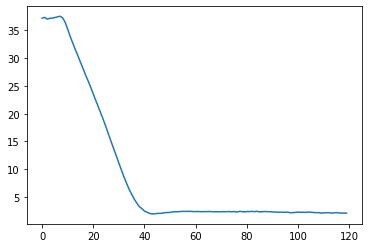

In [ ]:
# Best traj from true evaluation guided by BO
kl_cont_eval_opt
print(kl_cont_eval_opt)
plt.plot(kl_cont_eval_opt)

Manifold training at iter: 10


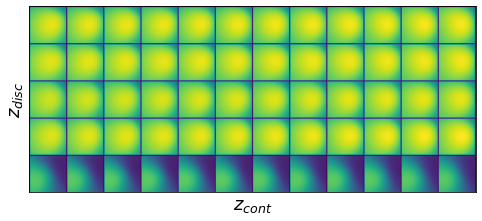

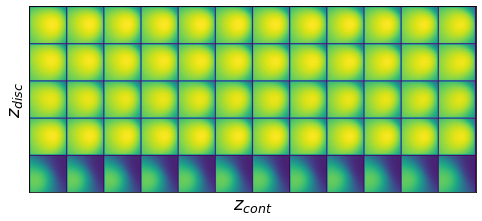

Manifold training at iter: 20


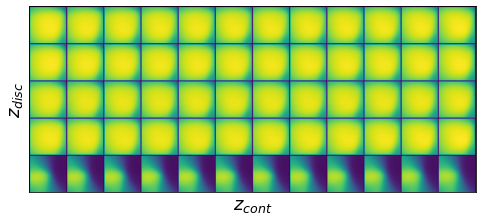

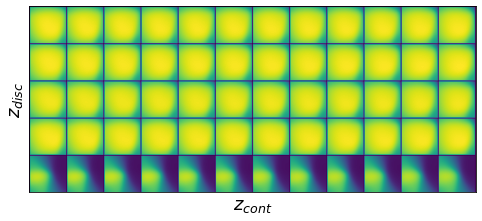

Manifold training at iter: 30


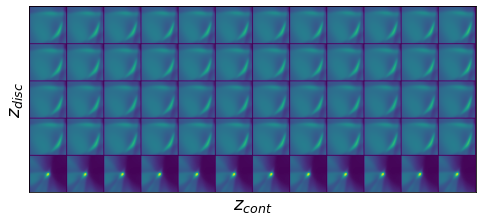

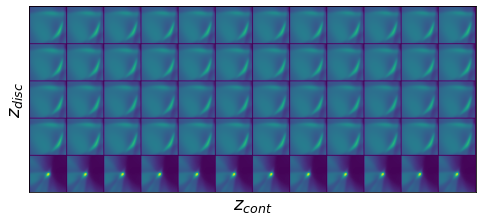

Manifold training at iter: 40


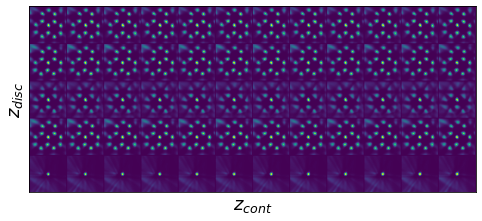

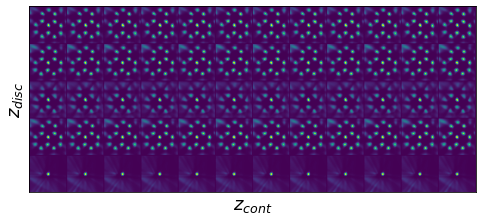

Manifold training at iter: 50


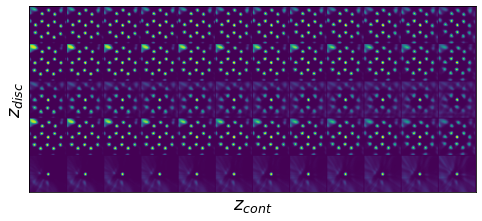

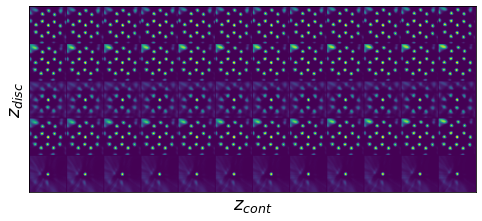

Manifold training at iter: 60


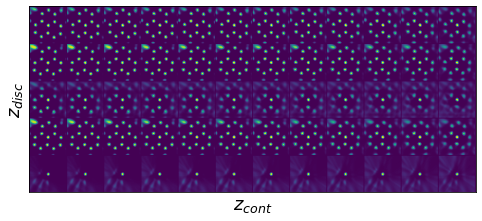

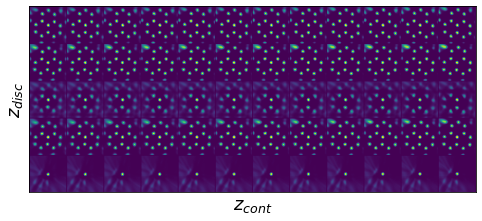

Manifold training at iter: 70


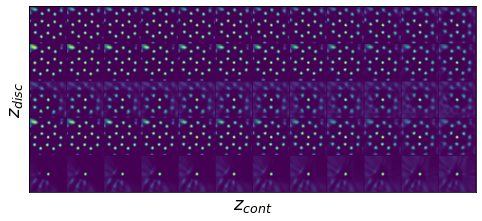

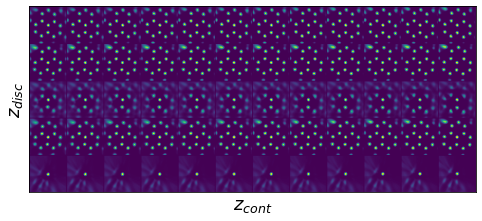

Manifold training at iter: 80


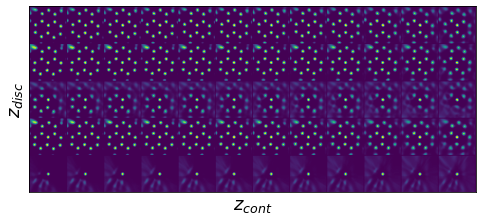

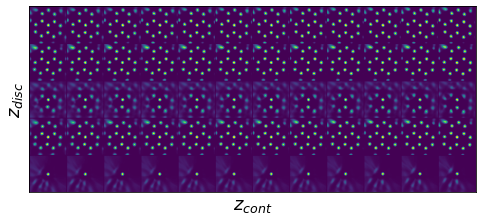

Manifold training at iter: 90


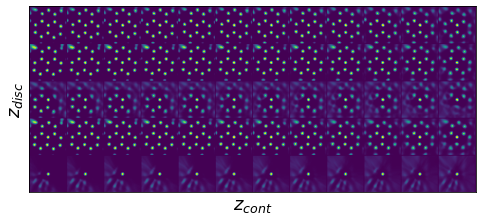

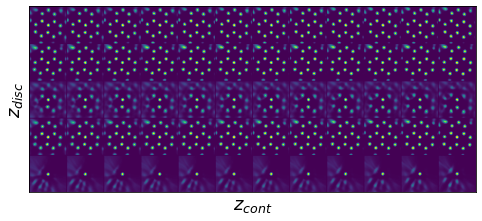

Manifold training at iter: 100


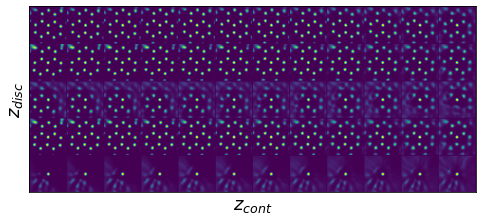

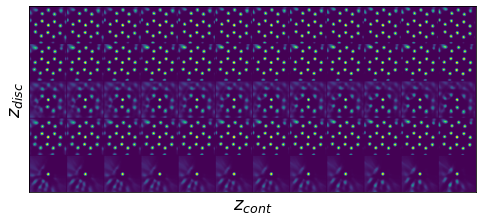

Manifold training at iter: 110


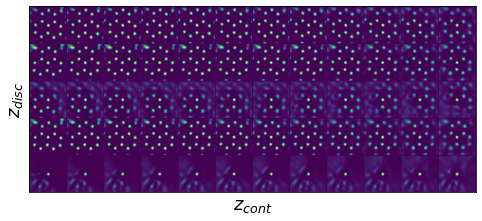

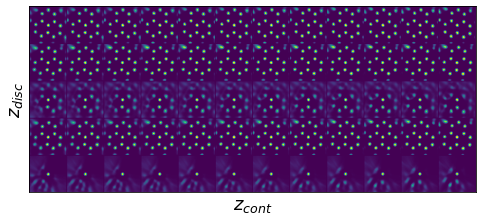

Manifold training at iter: 120


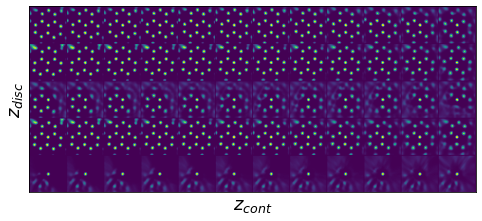

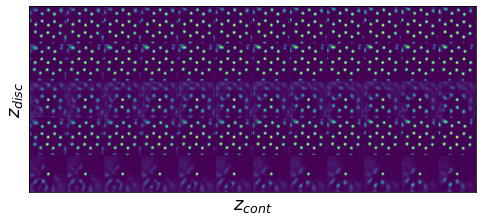

In [ ]:
#@title Train the VAE model- use the optimized kl trajectory from BO and full graphene data

train_loader_full = pv.utils.init_dataloader(train_data, batch_size=64)

# Input data dimensions
data_dim = (H, W)

# Initialize joint VAE model (note that we have to enter our "guess" about the number of discrete classes in the system)
jvae_full = pv.models.jiVAE(data_dim, latent_dim=2, discrete_dim=discrete_dim, invariances=['r'], seed=42)

# Initialize trainer (note that we are going to use parallel enumeration instead of Gumbel-Softmax approx)
trainer_full = pv.trainers.SVItrainer(jvae_full, lr=1e-3, enumerate_parallel=True)

#kl_d = kl_scale[-1]
kl_c = kl_cont_eval_opt
kl_c = kl_c.type(torch.DoubleTensor)
#kl_trajec = torch.cat(25*[kl_c])


for e in range(len(kl_c)):
    sc = kl_c[e] if e < len(kl_c) else kl_c[-1]
    #sc = 1
    trainer_full.step(train_loader_full, scale_factor=[sc, kl_d])  # [continuous, discrete] KL scale factors for continuous latent vars optimized
    #trainer.print_statistics()

    # Plot the traversal of the latent manifold learned so far
    if (e + 1) % 10 == 0:
        print ("Manifold training at iter: " +str(e+1))
        for i in range(2):
            jvae_full.manifold_traversal(B, i, cmap='viridis')

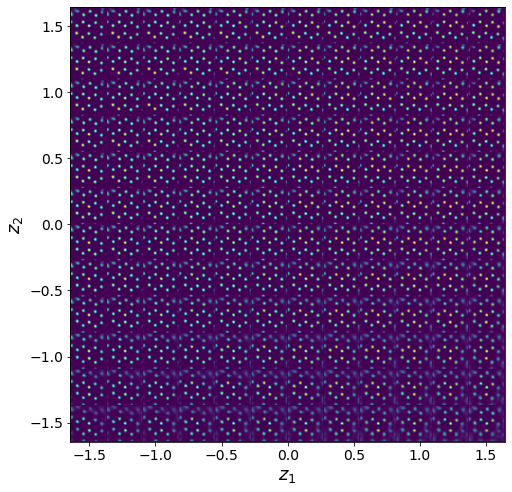

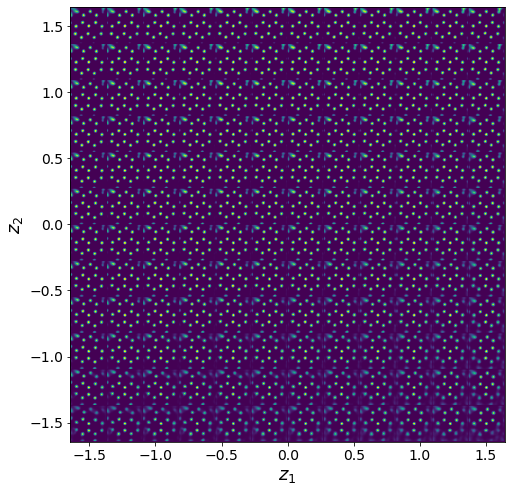

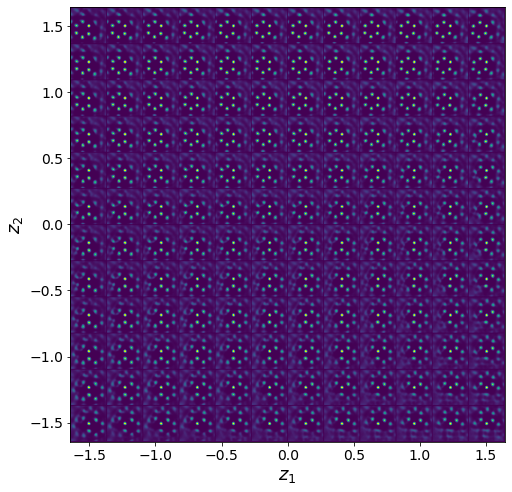

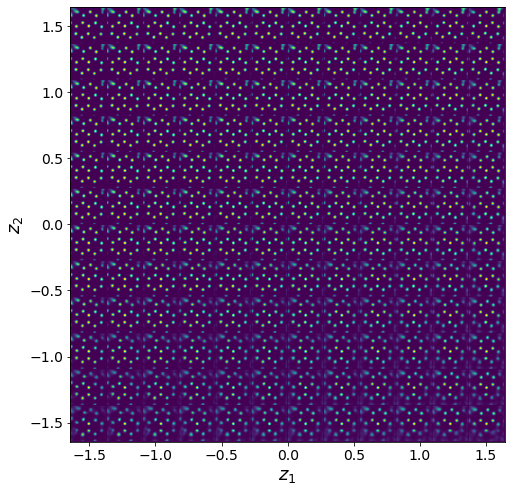

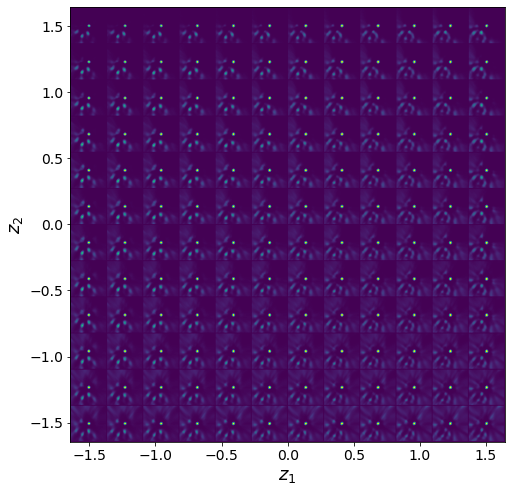

In [ ]:
#@title plot the trained manifolds using the optimized KL and full graphene data

M_full = torch.empty(B*B, H, W, discrete_dim)
loss_opt = 0
for i in range(discrete_dim):
    jvae_full.manifold2d(d=B, disc_idx=i, cmap='viridis')

#Questions

1. Do I need to restructure the script? Or the way of writing has dependencies to run in dgx box? This code has different models to run-- like VAE, iVAE and GP/BO with some maths calculations-- with having some inbuild python functions and self created functions. Will that be ok or I need to work on anything for compatibility issue with multi gpu run in dgx box?

2. Do I need to save this script locally first? In which format?

3. Any special cases to load the data or it will be the same way as we did for normal run (as per locally or in colab)?

4. How to get these results? Both data and figures after the respective dgx run is completed?